## Changing viscosity configuration - effect on tracers

Using the same external forcing as in CNTDIFF/run03, I modified the viscositi configuration in 5 runs (CNTDIFF/ run31-35). Here's a summary of those runs (all with 1 tracer, kv=10^-5 m^2/s)

|run| viscAh | viscAz |ViscSmag| viscAhRemax|viscAhGridMin|Unstable?| Tracer Kv|
|:--:|:-----:|:------:|:------:|:---------:|:------------:|:------:|:----------:|
| 03 | 1e-2  | 1e-2     |   2.2   |  10       |   0.01       |No      | 1E-5|
| 11 | 1e-2  | 1e-2     |   2.2   |  10       |   0.01       |No      | 1E-4|
| 12 | 1e-2  | 1e-2     |   2.2   |  10       |   0.01       |No      | 1E-3|
| 31 | 1e-5  | 1e-5     |   2.2   |  10       |   0.01       |No      | 1E-5|
| 32 | 1e-2  | 1e-2     |   -     |    -       |      -        |No      |1E-5|
| 33 | 1e-5  | 1e-5     |    -    |    -       |      -        |Yes     |1E-5|
| 34 |   -   | -         |   2.2  |    -       |      -        |No      |1E-5|
| 35 |   -   | -         |    -   |  10       |       -       |Yes     |1E-5|
| 36 |   -   | 1e-3      |  2.2   |  -       |       -       | No   |1E-3|
| 37 |   -   | 1e-4      |  2.2   |  -       |       -       | No   |1E-4|


If I specify smag then I don't need Ah. Defaults are 0.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from math import *

%matplotlib inline

from netCDF4 import Dataset

import seaborn as sns

import canyon_tools.readout_tools as rdout

import canyon_tools.metrics_tools as mpt


In [2]:
# load grid variables
Grid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
GridOut = Dataset(Grid)
GridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
GridNoCOut = Dataset(GridNoC)
State03 =  '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
State31 =  '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run31/stateGlob.nc'
State32 =  '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run32/stateGlob.nc'
State34 =  '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run34/stateGlob.nc'
State36 =  '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run36/stateGlob.nc'
State37 =  '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run37/stateGlob.nc'

StateOut =   Dataset('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc')

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rdout.getField(Grid, 'XC') # x coords tracer cells
yc = rdout.getField(Grid, 'YC') # y coords tracer cells
rc = GridOut.variables['RC']
z = StateOut.variables['Z']
times = StateOut.variables['T']

bathy = rdout.getField(Grid, 'Depth')

hFacC = rdout.getField(Grid, 'HFacC')
MaskC = rdout.getMask(Grid, 'HFacC')

rA = rdout.getField(GridNoC, 'rA') 
drF = GridNoCOut.variables['drF'] # vertical distance between faces
drC = GridNoCOut.variables['drC'] # vertical distance between centers
dxf = GridNoCOut.variables['dxF']

hFacCNoC = rdout.getField(GridNoC, 'HFacC')
mask_NoC = rdout.getMask(GridNoC, 'HFacC')


## Upwelling differences - vertically integrated tracer along shelf

In [3]:
def HCW_Tracer_AlongShelf(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

In [4]:
Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
Tr103 = rdout.getField(Ptracers,'Tr1')

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run12/ptracersGlob.nc'
Tr312 = rdout.getField(Ptracers,'Tr3')

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run11/ptracersGlob.nc'
Tr211 = rdout.getField(Ptracers,'Tr2')

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run31/ptracersGlob.nc'
Tr131 = rdout.getField(Ptracers,'Tr1')

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run32/ptracersGlob.nc'
Tr132 = rdout.getField(Ptracers,'Tr1')

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run34/ptracersGlob.nc'
Tr134 = rdout.getField(Ptracers,'Tr1')

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run36/ptracersGlob.nc'
Tr136 = rdout.getField(Ptracers,'Tr1')

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run37/ptracersGlob.nc'
Tr137 = rdout.getField(Ptracers,'Tr1')



In [5]:
HCW03,TrMASS03 = HCW_Tracer_AlongShelf(Tr103,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)
HCW31,TrMASS31 = HCW_Tracer_AlongShelf(Tr131,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)
HCW32,TrMASS32 = HCW_Tracer_AlongShelf(Tr132,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)
HCW34,TrMASS34 = HCW_Tracer_AlongShelf(Tr134,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)
HCW36,TrMASS36 = HCW_Tracer_AlongShelf(Tr136,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)
HCW37,TrMASS37 = HCW_Tracer_AlongShelf(Tr137,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)

HCW11,TrMASS11 = HCW_Tracer_AlongShelf(Tr211,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)
HCW12,TrMASS12 = HCW_Tracer_AlongShelf(Tr312,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)


('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)


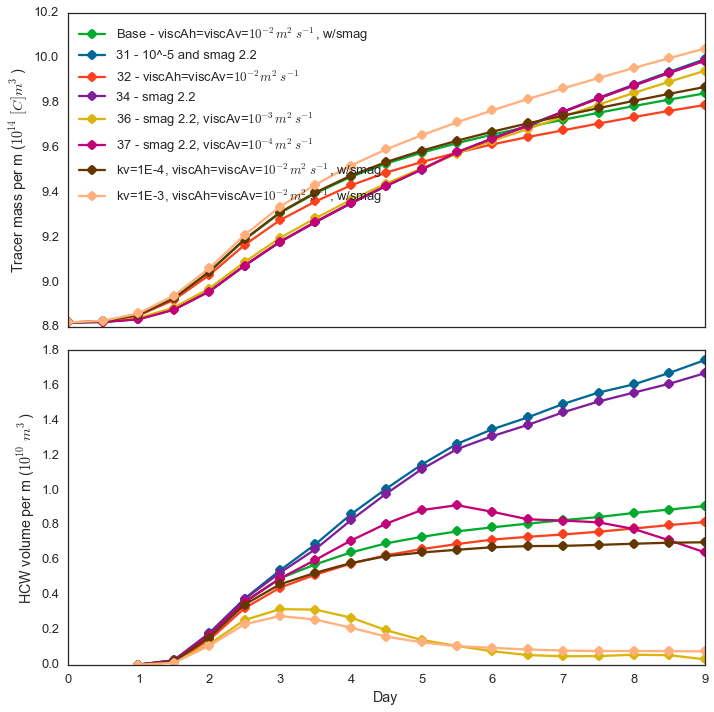

In [8]:
sns.set_context('talk')
sns.set_style('white')

fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.,np.sum(TrMASS03,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],
         marker = 'o',label='Base - viscAh=viscAv=$10^{-2}m^2s^{-1}$, w/smag')
ax1.plot(tt/2.,np.sum(TrMASS31,axis=1)/1.E14,sns.xkcd_rgb["peacock blue"],
         marker = 'o',label='31 - 10^-5 and smag 2.2')
ax1.plot(tt/2.,np.sum(TrMASS32,axis=1)/1.E14,sns.xkcd_rgb["orange red"],
         marker = 'o',label = '32 - viscAh=viscAv=$10^{-2}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMASS34,axis=1)/1.E14,sns.xkcd_rgb["purple"],
         marker = 'o',label='34 - smag 2.2')
ax1.plot(tt/2.,np.sum(TrMASS36,axis=1)/1.E14,sns.xkcd_rgb["gold"],
         marker = 'o',label='36 - smag 2.2, viscAv=$10^{-3}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMASS37,axis=1)/1.E14,sns.xkcd_rgb["magenta"],
         marker = 'o',label='37 - smag 2.2, viscAv=$10^{-4}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMASS11,axis=1)/1.E14,sns.xkcd_rgb["brown"],
         marker = 'o',label='kv=1E-4, viscAh=viscAv=$10^{-2}m^2s^{-1}$, w/smag')
ax1.plot(tt/2.,np.sum(TrMASS12,axis=1)/1.E14,sns.xkcd_rgb["peach"],
         marker = 'o',label='kv=1E-3, viscAh=viscAv=$10^{-2}m^2s^{-1}$, w/smag')

   
ax2.plot(tt/2.,np.sum(HCW03,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base')
ax2.plot(tt/2.,np.sum(HCW31,axis=1)/1.E10,sns.xkcd_rgb["peacock blue"],marker = 'o',label='31')
ax2.plot(tt/2.,np.sum(HCW32,axis=1)/1.E10,sns.xkcd_rgb["orange red"],marker = 'o',label='32')
ax2.plot(tt/2.,np.sum(HCW34,axis=1)/1.E10,sns.xkcd_rgb["purple"],marker = 'o',label='34')
ax2.plot(tt/2.,np.sum(HCW36,axis=1)/1.E10,sns.xkcd_rgb["gold"],marker = 'o',label='36')
ax2.plot(tt/2.,np.sum(HCW37,axis=1)/1.E10,sns.xkcd_rgb["magenta"],marker = 'o',label='37')
ax2.plot(tt/2.,np.sum(HCW11,axis=1)/1.E10,sns.xkcd_rgb["brown"],marker = 'o',label='11')
ax2.plot(tt/2.,np.sum(HCW12,axis=1)/1.E10,sns.xkcd_rgb["peach"],marker = 'o',label='12')
 
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
plt.tight_layout()

plt.show()